In [1]:
# to load pdf
from PyPDF2 import PdfReader

In [2]:
# extracting text from a pdf
inputfile = r'C:\MIDS\Project2SentimentAnalysisTranscripts\InTranscripts\Tesla Inc._Earnings Call_2023-04-19_English.pdf'
text=''
pdfObj = PdfReader(inputfile)
for page in pdfObj.pages:
    text += page.extract_text()

outfile = r'C:\MIDS\Project2SentimentAnalysisTranscripts\InTranscripts\TextProcessing\extractedText.txt'

with open(outfile, 'w') as file:
    file.write(text)


In [3]:
# for chunking the text
from langchain.text_splitter import CharacterTextSplitter

textSplitter = CharacterTextSplitter(separator='\n'
                                     , chunk_size = 1000
                                    , chunk_overlap = 200
                                    , length_function = len)

chunks =  textSplitter.split_text(text)
type(chunks), len(chunks)

(list, 82)

In [4]:
chunks[81]

"the right to disseminate its opinions and analyses. S&P Global's public ratings and analyses are made available on its Web sites, www.standardandpoors.com (free\nof charge), and www.ratingsdirect.com and www.globalcreditportal.com (subscription), and may be distributed through other means, including via S&P Global\npublications and third-party redistributors. Additional information about our ratings fees is available at www.standardandpoors.com/usratingsfees.\n© 2023 S&P Global Market Intelligence."

# text processing on chunks

In [4]:
# remove URL references from text
import re

def remove_url(text):
    # regular expression pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    cleaned_text =  re.sub(url_pattern, '', text)
    
    return cleaned_text

noUrlchunks=[]
noUrlText=''

for chunk in chunks:
    noUrlText=remove_url(chunk)
    noUrlchunks.append(noUrlText)



# make text lower case
lower_case_chunks = []
lowerCaseText=''

for chunk in noUrlchunks:
    lowerCaseText = chunk.lower()
    lower_case_chunks.append(lowerCaseText)
    
print(f'######## No URL########### \n{noUrlchunks[:2]}\n ############# Lower case ############## \n{lower_case_chunks[:2]}')

# remove punctuation    
def remove_punctuation(input_string):
    # Define a regular expression pattern to match punctuation characters
    pattern = r"[^\w\s]"
    
    # Substitute the punctuation characters with an empty string
    no_punct_string = re.sub(pattern, " ", input_string)
    
    return no_punct_string


# make text with no punctuations
no_punc_chunks = []
no_punc_text = ''

for chunk in lower_case_chunks:
    no_punc_text = remove_punctuation(chunk)
    no_punc_chunks.append(no_punc_text)

print (f'########## No punctuation ############## \n {no_punc_chunks[:2]}')
    

######## No URL########### 
['COPYRIGHT © 2023 S&P  Global Market  Intelligence, a  division of S&P Global  Inc. All rights reserved\nspglobal.com/marketintelligence1\nTesla, Inc. NasdaqGS:TSLA\nFQ1 2023  Earnings  Call Transcripts\nWednesday, April 19, 2023  9:30 PM GMT\nS&P Global Market Intelligence Estimates\n -FQ1 2023- -FQ2  2023- -FY 2023- -FY 2024-\n CONSENSUS ACTUAL SURPRISE CONSENSUS CONSENSUS CONSENSUS\nEPS Normalized  0.85 0.85\n 0.00 0.92 3.95 NA NA 5.50\nRevenue  (mm) 23355.07 23329.00\n (0.11  %) 24849.47 102499.69 NA NA 133639.51\nCurrency: USD\nConsensus as of  Apr-19-2023 10:24 PM GMT\n  - EPS NORMALIZED  -  \n CONSENSUS ACTUAL SURPRISE\nFQ2 2022 0.60 0.76\n 26.67  %\nFQ3 2022 1.00 1.05\n 5.00 %\nFQ4 2022 1.11 1.19\n 7.21 %\nFQ1 2023 0.85 0.85\n 0.00 %Contents\nCOPYRIGHT © 2023 S&P  Global Market  Intelligence, a  division of S&P Global  Inc. All rights reserved\nspglobal.com/marketintelligence2Table of Contents\n \nCall Participants ..................................

In [5]:
# Natural Language tool kit
import nltk

# tokenize words
from nltk.tokenize import word_tokenize

#  remove stop words

from nltk.corpus import stopwords
nltk.download('stopwords')

# performing only lemmatization and not stemming. Going by 
# https://www.datacamp.com/tutorial/stemming-lemmatization-python that
# indicates lemmatization as better though time-consuming compared to stemming
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")

def remove_stopwords(input_stringlist):
    filtered_words = [word for word in input_stringlist if word not in stopwords.words('english')]
    # filtered_string = ' '.join(filtered_words)
    return filtered_words



def lemmatizeText(input_stringlist):
    # Initialize wordnet lemmatizer
    wnl = WordNetLemmatizer()
    
    lemmatized_words = []
    for word in input_stringlist:
        lemmatized_words.append(wnl.lemmatize(word, pos="v"))
    
    lemmatized_string = ' '.join(lemmatized_words)
    return lemmatized_string #, lemmatized_words

processed__text_chunks = []

for chunk in no_punc_chunks:
    tokenized_chunk_text = word_tokenize(chunk) 
    # remove stop words from tokenized chunk
    no_stop_in_chunk = remove_stopwords(tokenized_chunk_text)
    lemmatized_chunk = lemmatizeText(no_stop_in_chunk)
    
    



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\martin.thomasmathew\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\martin.thomasmathew\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\martin.thomasmathew\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [7]:
len(no_punc_chunks)

82

In [8]:
# create prompt
# create prompt template
from langchain import PromptTemplate
# get response from OpenAI
from langchain.llms import OpenAI
from langchain.chains import LLMChain
# to reference envinronment variables
from dotenv import load_dotenv

load_dotenv()

template_for_prompt = '''For the following text - {chunk}, 
determine sentiment. Respond with 1 word: Negative, Positive, Neutral.
'''

prompt = PromptTemplate(
    input_variables=["chunk"],
    template = template_for_prompt
    )

llm = OpenAI()
chain = LLMChain(llm = llm, prompt = prompt)
#chain.run('no_punc_chunks')
sentiment_for_chunks = []
for c in no_punc_chunks:
    response = chain.run(c)
    print(response)
    sentiment_for_chunks.append(response)
    
import statistics
from statistics import mode    
document_sentiment = mode(sentiment_for_chunks)

print (f'The overall sentiment of the transcript: {document_sentiment}')


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Neutral


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Neutral.


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Neutral

Neutral

Neutral

Neutral


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Neutral


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Neutral

Neutral

Neutral

Negative

Neutral

Neutral

Negative

Neutral

Neutral

Neutral

Neutral

Neutral

Neutral

Neutral

Positive

Negative


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Neutral

Neutral

Negative


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Negative

Positive

Neutral
Neutral

Neutral

Negative

Negative


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Negative

Negative.

Negative


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Neutral


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Negative

Neutral

Neutral

Neutral

Negative

Neutral


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Negative


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Negative


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Neutral


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Neutral

Neutral.

Positive

Neutral

Andrew: Neutral
Elon: Positive
Martin: Neutral

Negative

Neutral

Negative

Neutral

Negative


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Neutral


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Neutral


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Neutral


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Neutral

Positive

Neutral


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Negative

Neutral


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 8.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.


Neutral

Negative


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Negative

Neutral

Positive


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Neutral

Neutral

Neutral


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Negative


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Negative

Neutral


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Negative

Negative

Negative


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Negative

Neutral


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: The server had an error while processing your request. Sorry about that!.



Neutral

Neutral
The overall sentiment of the transcript: 
Neutral


In [7]:
## for the sentiment array ensure all the items has just 1 of 3 values - postive, neutral, negative

for i in range(len(sentiment_for_chunks)):
    if 'Positive'in sentiment_for_chunks[i]:
        sentiment_for_chunks[i] = 'Positive'
    elif 'Negative' in sentiment_for_chunks[i]:
        sentiment_for_chunks[i] = 'Negative'
    else:
        sentiment_for_chunks[i] = 'Neutral'

sentiment_for_chunks

# save the list into a file so you dont have to call openai always for learning
outfile5 = r'C:\MIDS\Project2SentimentAnalysisTranscripts\InTranscripts\TextProcessing\sentimentForChunks.txt'

with open(outfile5, 'w') as fp:
    for item in sentiment_for_chunks:
        # write each ibtem on a new line
        fp.write("%s\n" % item)
    print('Done')


['Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Negative',
 'Neutral',
 'Neutral',
 'Negative',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Negative',
 'Neutral',
 'Neutral',
 'Negative',
 'Negative',
 'Positive',
 'Neutral',
 'Neutral',
 'Neutral',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Neutral',
 'Negative',
 'Neutral',
 'Neutral',
 'Neutral',
 'Negative',
 'Neutral',
 'Negative',
 'Negative',
 'Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Neutral',
 'Positive',
 'Negative',
 'Neutral',
 'Negative',
 'Neutral',
 'Negative',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Neutral',
 'Negative',
 'Neutral',
 'Neutral',
 'Negative',
 'Negative',
 'Neutral',
 'Positive',
 'Neutral',
 'Neutral',
 'Neutral',
 'Negative',
 'Negative',
 'Neutral',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Neutral',
 'Neutra

In [4]:
outfile5 = r'C:\MIDS\Project2SentimentAnalysisTranscripts\InTranscripts\TextProcessing\sentimentForChunks.txt'

# read file into a list so you dont have to call openai
with open(outfile5) as f:
    sentiment_for_chunks_read_from_file = f.read().splitlines()

sentiment_for_chunks_read_from_file

['Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Negative',
 'Neutral',
 'Neutral',
 'Negative',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Negative',
 'Neutral',
 'Neutral',
 'Negative',
 'Negative',
 'Positive',
 'Neutral',
 'Neutral',
 'Neutral',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Neutral',
 'Negative',
 'Neutral',
 'Neutral',
 'Neutral',
 'Negative',
 'Neutral',
 'Negative',
 'Negative',
 'Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Neutral',
 'Positive',
 'Negative',
 'Neutral',
 'Negative',
 'Neutral',
 'Negative',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Neutral',
 'Negative',
 'Neutral',
 'Neutral',
 'Negative',
 'Negative',
 'Neutral',
 'Positive',
 'Neutral',
 'Neutral',
 'Neutral',
 'Negative',
 'Negative',
 'Neutral',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Neutral',
 'Neutra

In [7]:
# initialize data frame to store the results of above
# df has columns - company, file name, data of publication, avg of positive, avg of negative, avg of neutral, overall sentiment

# for working with dataframes
import pandas as pd

# initialize a dataframe
df_docresult = pd.DataFrame(columns=['company','filename','publicationDate', 'avg.Postive','avg.Negative'
                                    ,'avg.Neutral','overallSentiment'])

company='Tesla'
filename='Earnings Call'
publicationDate='2023-04-19'
document_sentiment = 'Neutral'


def sentimentAvg(sentimentList):
    '''
    Arg:
    sentimentList - list with value of neutral, positive, negative
    
    Returns:
    avg. Positive, Negative, Neutral metrics of the list.
    '''
    positive_count = neutral_count = negative_count = 0.0
    
    for i in range(len(sentimentList)):
        if sentimentList[i] == 'Positive':
            positive_count += 1
        elif sentimentList[i] == 'Negative':
            negative_count += 1
        else:
            neutral_count += 1
        
    avg_positive = positive_count/len(sentimentList)
    avg_negative = negative_count/len(sentimentList)
    avg_neutral = neutral_count/len(sentimentList)
    
    print(f'avg_positive:\t{avg_positive}\navg_negative:\t{avg_negative}\navg_neutral:\t{avg_neutral}')
    
    return avg_positive, avg_negative, avg_neutral

avgPositive, avgNegative, avgNeutral = sentimentAvg(sentiment_for_chunks_read_from_file)
    
# append row of data to dataframe
df_docresult = pd.concat([pd.DataFrame([[company
                                         , filename
                                         , publicationDate
                                         , avgPositive
                                         , avgNegative
                                         , avgNeutral
                                         , document_sentiment
                                        ]], columns=df_docresult.columns), df_docresult], ignore_index=True)

df_docresult

avg_positive:	0.07317073170731707
avg_negative:	0.3170731707317073
avg_neutral:	0.6097560975609756


,company,filename,publicationDate,avg.Postive,avg.Negative,avg.Neutral,overallSentiment
0,Tesla,Earnings Call,2023-04-19,0.073171,0.317073,0.609756,Neutral


# Visualization

In [54]:
### working ########
company = 'Tesla2'
companyFile = open('C:\MIDS\Project2SentimentAnalysisTranscripts\InTranscripts\sentimentDF\companyList.txt', 'a+')
companyFile.seek(0)
if company not in companyFile.read():
    companyFile.write(company)
    companyFile.write('\n')

companyFile.seek(0)
allcompanies=companyFile.read()
companyList = allcompanies.splitlines()
companyList


['Hello', 'Hello', 'Hello2', 'Tesla', 'Tesla', 'Tesla1', 'Tesla2']

In [11]:
# for working with dataframes
import pandas as pd

save_df_location = 'C:\MIDS\Project2SentimentAnalysisTranscripts\InTranscripts\sentimentDF\\'

company = 'Tesla'

full_file_location = save_df_location + company + '-sentMetrics.csv'
metricsdf = pd.read_csv(full_file_location)

metricsdf
# metricsdf.dtypes

metricsdf.sort_values(by='publicationDate', inplace = True)

# Unnamed: 0            int64
# company              object
# publicationDate      object
# filename             object
# avg.Postive         float64
# avg.Negative        float64
# avg.Neutral         float64
# overallSentiment     object
# dtype: object


,Unnamed: 0,company,publicationDate,filename,avg.Postive,avg.Negative,avg.Neutral,overallSentiment
1,1,Tesla,2021-07-26,Tesla Inc._Earnings Call_2021-07-26_English.pdf,0.281690,0.211268,0.507042,Neutral
2,2,Tesla,2021-10-20,Tesla Inc._Earnings Call_2021-10-20_English.pdf,0.271605,0.259259,0.469136,Neutral
3,3,Tesla,2022-01-26,Tesla Inc._Earnings Call_2022-01-26_English.pdf,0.214286,0.171429,0.614286,Neutral
4,4,Tesla,2022-04-20,Tesla Inc._Earnings Call_2022-04-20_English.pdf,0.240506,0.291139,0.468354,Neutral
5,5,Tesla,2022-07-20,Tesla Inc._Earnings Call_2022-07-20_English.pdf,0.237500,0.300000,0.462500,Neutral
6,6,Tesla,2022-10-19,Tesla Inc._Earnings Call_2022-10-19_English.pdf,0.226667,0.253333,0.520000,Neutral
7,7,Tesla,2023-01-25,Tesla Inc._Earnings Call_2023-01-25_English.pdf,0.160000,0.293333,0.546667,Neutral
0,0,Tesla,2023-03-01,Tesla Inc._Analyst or Investor Day_2023-03-01_...,0.274900,0.163347,0.561753,Neutral
8,8,Tesla,2023-04-19,Tesla Inc._Earnings Call_2023-04-19_English.pdf,0.170732,0.256098,0.573171,Neutral


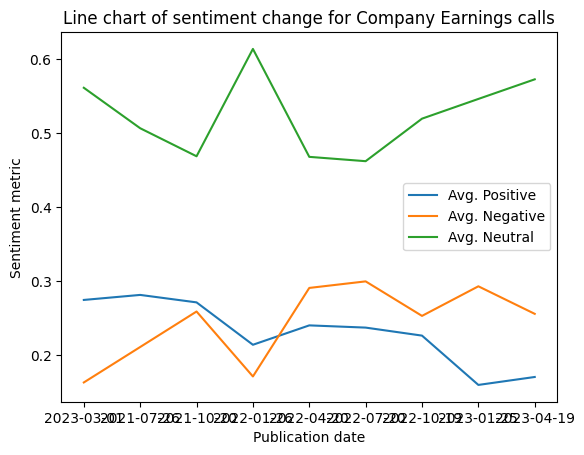

In [13]:
# plot chart
import matplotlib.pyplot as plt

plt.plot(metricsdf['publicationDate'], metricsdf['avg.Postive'], label= 'Avg. Positive')
plt.plot(metricsdf['publicationDate'], metricsdf['avg.Negative'], label= 'Avg. Negative')
plt.plot(metricsdf['publicationDate'], metricsdf['avg.Neutral'], label= 'Avg. Neutral')

# Add labels and title
plt.xlabel('Publication date')
plt.ylabel('Sentiment metric')
plt.title('Line chart of sentiment change for Company Earnings calls')

# display legend
plt.legend()

# show the plot
plt.show()


################# Rough below #########################

In [3]:
# remove URL references from text
import re

def remove_url(text):
    # regular expression pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    cleaned_text =  re.sub(url_pattern, '', text)
    
    return cleaned_text

text_withno_urls = remove_url(text)

outfile1 = r'C:\MIDS\Project2SentimentAnalysisTranscripts\InTranscripts\TextProcessing\extractedTextNoURLs.txt'

with open(outfile1, 'w') as file:
    file.write(text_withno_urls)

In [4]:
type(text_withno_urls)

str

In [5]:
# converting all letters to lower or upper case
text_lower_case = text_withno_urls.lower()
# remove punctuations

def remove_punctuation(input_string):
    # Define a regular expression pattern to match punctuation characters
    pattern = r"[^\w\s]"
    
    # Substitute the punctuation characters with an empty string
    no_punct_string = re.sub(pattern, "", input_string)
    
    return no_punct_string

text_no_punct = remove_punctuation (text_lower_case)# .replace(symbol, ' ')

outfile2= r'C:\MIDS\Project2SentimentAnalysisTranscripts\InTranscripts\TextProcessing\textNoPunctuations.txt'

with open(outfile2, 'w') as file:
    file.write(text_no_punct)

In [6]:
# read text preprocessing
# tokenize words
from nltk.tokenize import word_tokenize

text_tokenized = word_tokenize(text_no_punct)
text_tokenized_to_write_to_file = ','.join(text_tokenized)

outfile2 = r'C:\MIDS\Project2SentimentAnalysisTranscripts\InTranscripts\TextProcessing\tokenizedText.txt'

with open(outfile2, 'w') as file:
    file.write(text_tokenized_to_write_to_file)


In [7]:
#  remove stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stopwords(input_stringlist):
    filtered_words = [word for word in input_stringlist if word not in stopwords.words('english')]
    filtered_string = ' '.join(filtered_words)
    return filtered_string, filtered_words

text_with_no_stopwords, textlist_with_no_stopwords = remove_stopwords(text_tokenized)


outfile3 = r'C:\MIDS\Project2SentimentAnalysisTranscripts\InTranscripts\TextProcessing\textNoStopWords.txt'

with open(outfile3, 'w') as file:
    file.write(text_with_no_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\martin.thomasmathew\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# performing only lemmatization and not stemming. Going by 
# https://www.datacamp.com/tutorial/stemming-lemmatization-python that
# indicates lemmatization as better though time-consuming compared to stemming
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")

def lemmatizeText(input_stringlist):
    # Initialize wordnet lemmatizer
    wnl = WordNetLemmatizer()
    
    lemmatized_words = []
    for word in input_stringlist:
        lemmatized_words.append(wnl.lemmatize(word, pos="v"))
    
    lemmatized_string = ' '.join(lemmatized_words)
    return lemmatized_string, lemmatized_words


text_lemmatized, textlist_lemmatized = lemmatizeText(textlist_with_no_stopwords)

outfile4 = r'C:\MIDS\Project2SentimentAnalysisTranscripts\InTranscripts\TextProcessing\textLemmatized.txt'

with open(outfile4, 'w') as file:
    file.write(text_lemmatized)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\martin.thomasmathew\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\martin.thomasmathew\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# chunk it up. chunk by character count/tokens. see grzegorz image
